In [1]:
import numpy as np
import fitsio as ft
import healpy as hp

import sys
path2git = '/users/PHS0336/medirz90/github'
sys.path.insert(0, f'{path2git}/sysnetdev')
sys.path.insert(0, f'{path2git}/LSSutils')

from lssutils.utils import hpix2radec, make_hp
from lssutils.stats.nnbar import MeanDensity
from lssutils.dataviz import setup_color
from scipy.stats import binned_statistic

import matplotlib.pyplot as plt

from glob import glob

In [2]:
import corner
from getdist import plots, MCSamples

In [4]:
def hist(ngal, frac, syst, bins):
    ng,_,_ = binned_statistic(syst, ngal, statistic='sum', bins=bins)
    nr,_,_ = binned_statistic(syst, frac, statistic='sum', bins=bins)
    ns,_,_ = binned_statistic(syst, syst, statistic='mean', bins=bins)
    
    #nstd,_,_ = binned_statistic(syst, ngal/frac, statistic=np.std, bins=bins)
    #nmodes,_,_ = binned_statistic(syst, np.ones(syst.size), statistic='count', bins=bins)
    norm = ng.sum()/nr.sum()
    mean = ng/(nr*norm)
    #err = nstd/np.sqrt(nmodes)
    return (ns, mean)

def model(x, theta):
    """ Linear model """
    return x.dot(theta[1:]) + theta[0]


def makehp_wlin(xs, theta, hpix):
    p = [7.26384087, 1.91704688]
    w_s = model(xs, theta)
    w_ = (w_s*p[1])+p[0]
    
    w_w = w_ / w_.mean()
    w_w = w_w.clip(0.5, 2.0)    
    
    return makehp(hpix, w_w, 1024)

In [7]:
class Chains:
    
    def __init__(self, filename):
    
        chains_ = np.load(filename, allow_pickle=True)
        self.chains = chains_['chain']
        print(self.chains.shape)

        fg, ax = plt.subplots(nrows=14, figsize=(8, 14*1), sharex=True)#, sharey=True)
        ax = ax.flatten()
        #ax[0].set_ylim(-.5, .5)

        for i, ix in enumerate(range(14)): #[0, 1, 2, 3, 5]):
            for j in range(400):
                ax[i].plot(self.chains[:, j, ix])

            ax[i].axhline(0.0, ls=':')    
        fg.show()
        
    def get_sample(self, skip_rows=200):
        return self.chains[skip_rows:, :, :].reshape(-1, 14)

(1000, 400, 14)
(1000, 400, 14)
(1000, 400, 14)


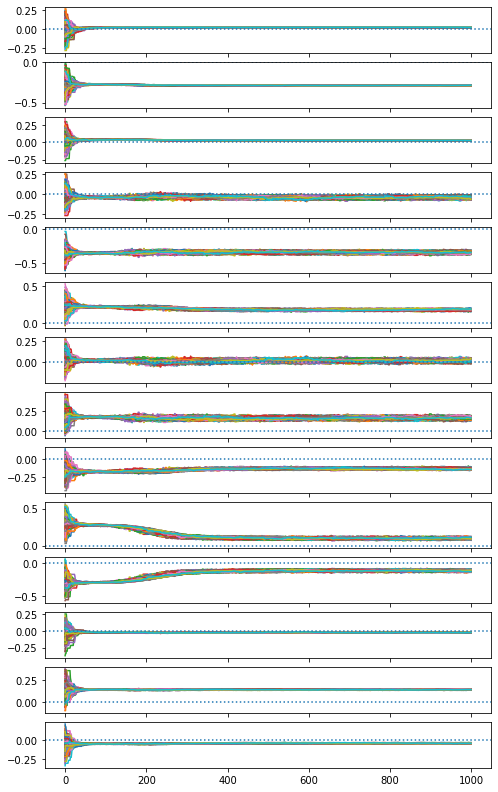

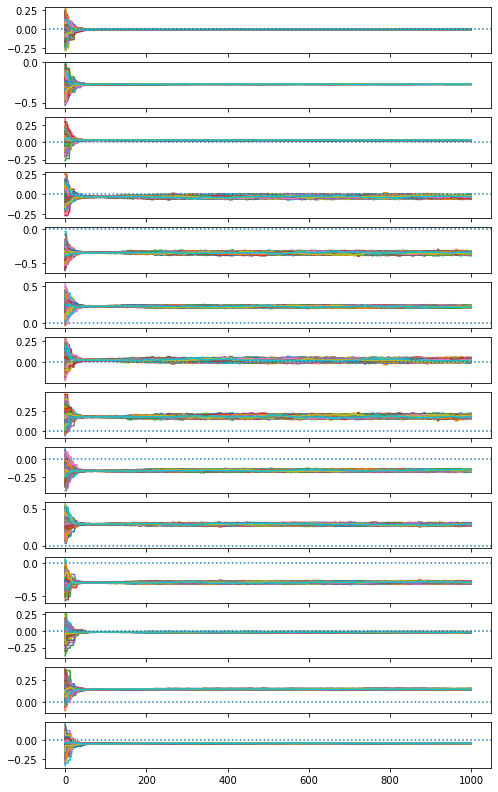

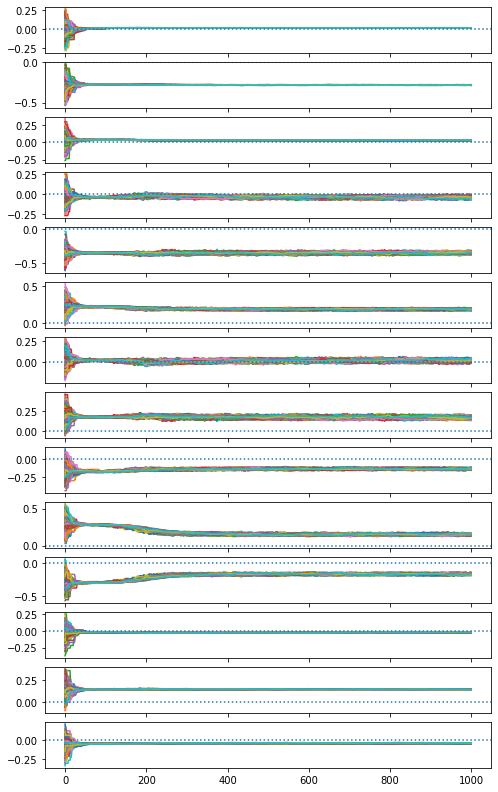

In [8]:
ch1 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/elg_linear/mcmc_bmzls_1024wfrac.npz')
ch2 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/elg_linear/mcmc_bmzls_1024.npz')
ch3 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/elg_linear/mcmc_bmzls_1024wfracsq.npz')

In [7]:
s1 = ch1.get_sample()
s2 = ch2.get_sample()
s3 = ch3.get_sample()

In [8]:
columns = np.array(['C', 'EBV', 'STARDENS']\
          + [f'galdepth_{b}mag_ebv' for b in ['r', 'g', 'z']]\
          + [f'psfdepth_{b}mag_ebv' for b in ['r', 'g', 'z', 'w1', 'w2']] \
          + [f'PSFSIZE_{b}' for b in ['R', 'G', 'Z']]) # 
len(columns)

14

In [9]:
ix = [0, 1, # c, e[b-v] 
      3, 6, # depth_r, psfdepth_r
      11, 12] # psfsize-r, psfsize-g

samples1 = MCSamples(samples=s1[:, ix], names=columns[ix], labels=columns[ix], label=r'frac$^{2}$')
samples2 = MCSamples(samples=s2[:, ix], names=columns[ix], labels=columns[ix], label='no weight')
samples3 = MCSamples(samples=s3[:, ix], names=columns[ix], labels=columns[ix], label='frac')

Removed no burn in
Removed no burn in
Removed no burn in


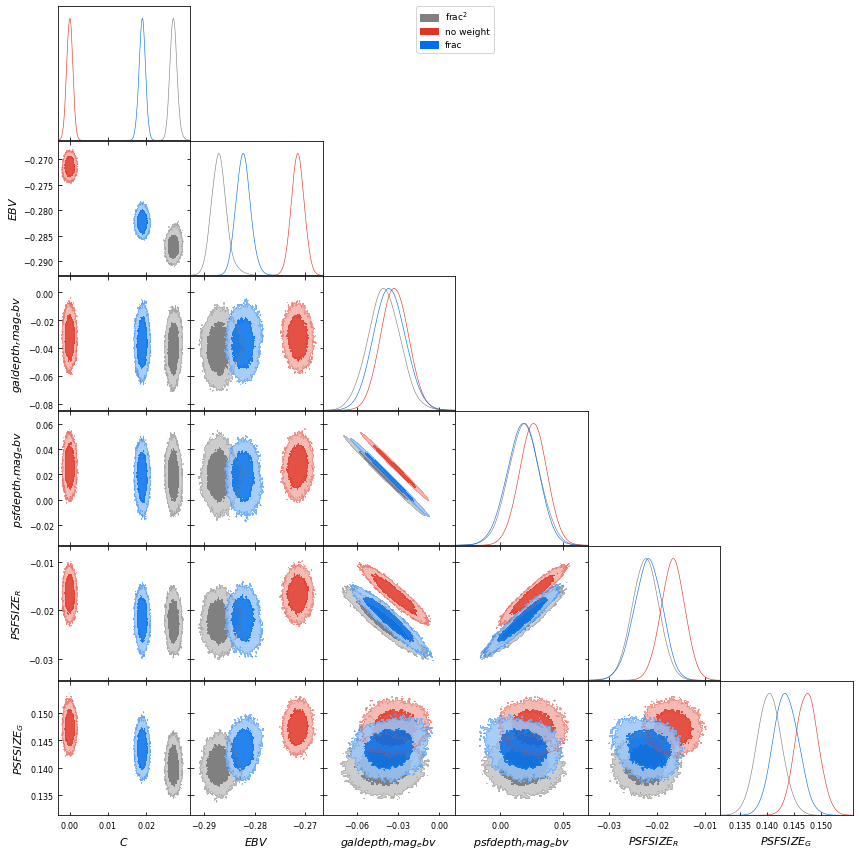

In [10]:
# Triangle plot
g = plots.get_subplot_plotter()
g.triangle_plot([samples1, samples2, samples3], filled=True)

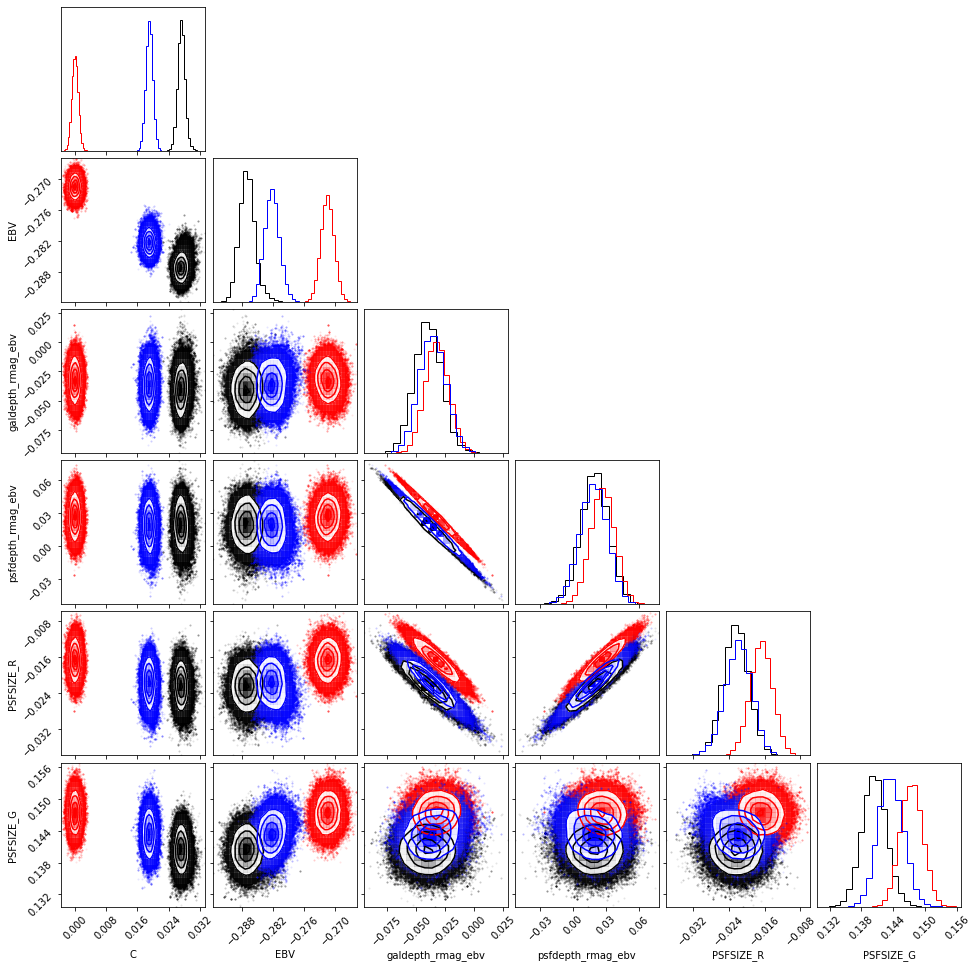

In [13]:
ix = [0, 1, # c, e[b-v] 
      3, 6, # depth_r, psfdepth_r
      11, 12] # psfsize-r, psfsize-g
fg = corner.corner(s1[:, ix], labels=columns[ix], )
corner.corner(s2[:, ix], labels=columns[ix], color='r', fig=fg)
corner.corner(s3[:, ix], labels=columns[ix], color='b', fig=fg)
# fg.legend()
plt.show()

In [5]:
df = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/nelg_features_bmzls_1024.fits')
print(df.dtype.names)

ngal = make_hp(1024, df['hpix'], df['label'])
syst = make_hp(1024, df['hpix'], df['features'][:, 0])
mask = make_hp(1024, df['hpix'], 1.0) > 0
frac = make_hp(1024, df['hpix'], df['fracgood'], True)

print(np.percentile(ngal[mask], [2.5, 97.5]))

('features', 'label', 'fracgood', 'hpix')
[ 3.75 11.25]


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


[0.87883425 1.01799889]


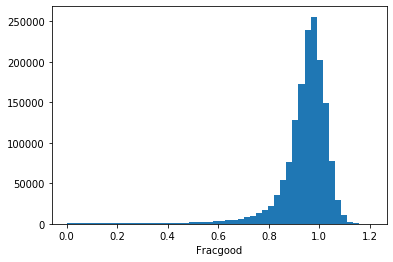

In [6]:
_ = plt.hist(frac, bins=50)
plt.xlabel('Fracgood')
print(np.percentile(frac[mask], [15, 85]))

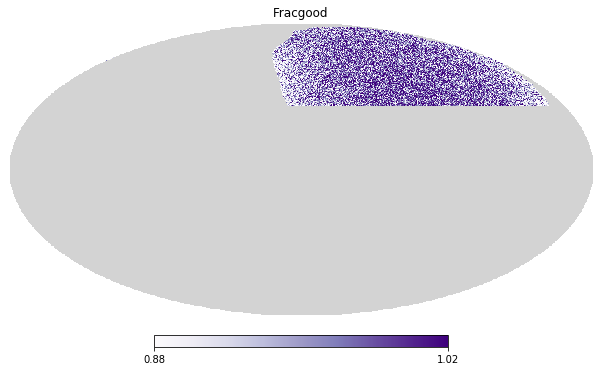

In [9]:
hp.mollview(frac, rot=-90, cmap=plt.cm.Purples,
            min=0.88, max=1.02, badcolor='lightgrey', title='Fracgood')

In [13]:
bins = np.linspace(*np.percentile(syst[mask], [1, 99]), num=9)
bins

array([0.00687821, 0.02525393, 0.04362964, 0.06200535, 0.08038106,
       0.09875677, 0.11713248, 0.13550819, 0.1538839 ])

In [14]:
r = {}

#nbar = MeanDensity(ngal, frac, mask, syst, bins=bins, binning='simple', nbins=8)
#nbar.run()
r['DR9 ELGs'] = hist(ngal[mask], frac[mask], syst[mask], bins)

In [15]:
xs = (df['features'] - chains_['x'][0]) / chains_['x'][1]

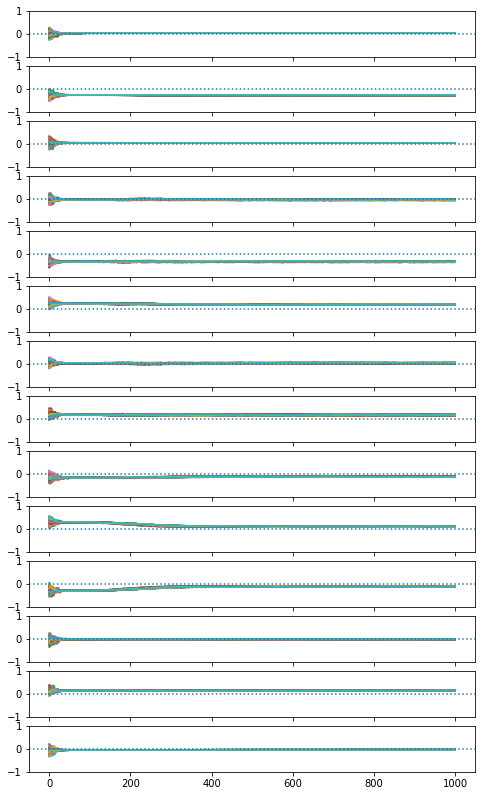

In [21]:
fg, ax = plt.subplots(nrows=14, figsize=(8, 14*1), sharex=True, sharey=True)
ax = ax.flatten()
ax[0].set_ylim(-1., 1.)

for i, ix in enumerate(range(14)): #[0, 1, 2, 3, 5]):
    for j in range(400):
        ax[i].plot(chains[:, j, ix])
        
    ax[i].axhline(0.0, ls=':')

(360000, 14)

In [43]:
ix = np.random.choice(np.arange(chains_red1.shape[0]), size=100, replace=False)

for i in ix:
    whp = makehp_wlin(xs, chains_red1[i, :], df['hpix'])
    r['mock_%d'%i] = hist(whp[mask], frac[mask], syst[mask], bins)
    print('.', end='')

....................................................................................................

Text(0, 0.5, 'Mean Density')

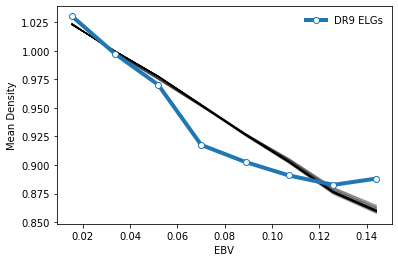

In [44]:
for name, val in r.items():
    #if np.any(val[1] < 0.9):
    #    print(name)
    #    continue
    if name == 'DR9 ELGs':
        plt.plot(val[0], val[1], marker='o', mfc='w', ls='-', label=name, lw=4)
    else:
        plt.plot(val[0], val[1], lw=1, color='k', ls='-', zorder=-1, alpha=0.1)
        
plt.legend(frameon=False)
plt.xlabel('EBV')
plt.ylabel('Mean Density')
# plt.savefig('/home/mehdi/data/tanveer/elg_mse_snapshots/ngal_loghi.png', 
#             dpi=300, bbox_inches='tight')